In [1]:
import torch
import numpy as np
import pandas as pd
import random
import time
import math
import geopandas as gpd
from itertools import repeat
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import TimeSeriesSplit
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F

from IST_models import *
from IST_dataset import *

from utils import *
from torch_geometric.loader import DataLoader

from torch.autograd import Variable

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
target_df = pd.read_pickle("data/PARKING/raw/target_df_aantal_cleaned_new.pkl").dropna(how="all")
buurt_polygons = pd.read_pickle("data/PARKING/raw/buurt_polygons.pkl")
dataset_root = 'data/PARKING/'
model_root = 'data/MODELS/'
model_name = "Graph_Sage_mean"

model_dict = {
    "Graph_Sage_pool": {
        "edge_params": {
            "project": True,
            "activation": "relu",
            "initial_loops": False,
            "with_nodes_own": True,
        },
        "node_params": {
            "edge_to_node_aggr": "max",
            "project": True,
            "activation": "relu",
            "with_nodes_own": True,
        },
        "selection_params": {
            "remove_self_loops": True
        }
    },
    "Graph_Sage_mean": {
        "edge_params": {
            "edge_att_norm": "mean",
            "project": False,
            "initial_loops": False,
            "with_nodes_own": True
        },
        "node_params": {
            "edge_to_node_aggr": "sum",
            "project": True,
            "activation": "relu",
            "with_nodes_own": True,
        },
        "selection_params": {
            "remove_self_loops": True
        }
    },
    "Graph_Sage_vanilla_GCN": {
        "edge_params": {
            "edge_att_norm": "mean",
            "project": False,
            "initial_loops": True,
            "with_nodes_own": True,
        },
        "node_params": {
            "edge_to_node_aggr": "sum",
            "project": True,
            "activation": "relu",
        },
        "selection_params": {
        }
    },
    "Graph_Sage_GCN": {
        "edge_params": {
            "edge_att_norm": "symmetric",
            "project": False,
            "initial_loops": True,
            "with_nodes_own": True,
        },
        "node_params": {
            "edge_to_node_aggr": "sum",
            "project": True,
            "activation": "relu",
        },
        "selection_params": {
        }
    },
    "Graph_Attention": {
        "edge_params": {
            "edge_att_norm": "attention",
            "project": True,
            "bias": False,
            "activation": None,
            "initial_loops": True,
            "with_nodes_own": True
        },
        "node_params": {
            "edge_to_node_aggr": "sum",
            "project": False,
            "activation": "relu"
        },
    }
}

pooling_dict = {
    "edge_params": {
        "broadcast_method": "reverse_cluster",
        "with_edge_weights": False
    },
    "node_params": {
        "broadcast_method": "reverse_cluster",
        "normalize": True,
        "dropout_prob" : 0.00
    },
    "selection_params": {
        "selection_meth": "mlp",
        "edge_to_edge_aggr": "sum",
        "node_to_node_aggr": "sum",
        "project": True,
        "softmax_direction": -1,
        "normalize_adj": True
    }
}

layer_dict = {
    "emb_params": {
        "with_nodes_below": True,
        "with_nodes_above": True,
        "with_globals": True,
        "with_nodes_depth": True,
        "with_selection_depth": True
    },
    "pro_params": {
        "with_nodes_below": False,
        "with_nodes_above": False,
    },
    "dec_params": {
        "with_nodes_below": True,
        "with_nodes_above": True,
        "with_globals": True,
        "with_nodes_depth": True,
        "with_selection_depth": True
    }
}

setup_dict = {"HMGN_emb": True, "HMGN_dec": True, "pos_encoding": False, "pos_enc_dim": 10,
              "n_hid_layer": 2, "emb_bias": True, "return_type": "node_level", "patience": 15, 
              "reduce_factor": 0.5, "initial_lr": 1e-3, "stop_learning_rate": 1e-5, "max_epochs": 200, "seq_len": 8, 
              "n_heads": 8, "seed": 0, "weight_decay": 0.0}


n_cluster_with_hid_list = [
    # ["Graph_Sage_pool", [4, 1], 90], 
    # ["Graph_Sage_GCN", [6], 116],
    # ["Graph_Sage_vanilla", [], 146],
    ["Graph_Sage_mean", [], 50],
    ["Graph_Attention", [], 41],
    # ["Graph_Sage_mean", [64, 32, 6], 60],
    # ["Graph_Sage_mean", [32, 6], 131],
    # ["Graph_Sage_pool", [10], 59], 
    # ["Graph_Sage_GCN", [10], 100],
    # ["Graph_Sage_vanilla", [10], 100],
    # ["Graph_Attention", [8], 20],
    ]

loss_fn = nn.MSELoss()

training = True
testing = True

n_splits = 3
test_idx = 2

params = {'batch_size': 32,
          'drop_last' : True,
          'shuffle' : False
         }

input_list = [
    ["cyclical_hour", "cyclical_day", "bbga", "centroid", "historical", "weather", "npr"],    
    # ["cyclical_hour", "cyclical_day", "historical"],
#     ["cyclical_hour", "cyclical_day", "historical", "delta"],
#     ["cyclical_hour", "cyclical_day", "weather", "historical", "delta"],
#     ["cyclical_hour", "cyclical_day", "weather", "historical", "delta", "npr"],
    # ["historical", "cyclical_hour", "cyclical_day", "bbga", "centroid", "weather", "npr"],
    # ["bbga", "centroid"]
][::-1]

# input_list = [
# #     ["historical", "bbga"],
# #     ["historical", "cyclical_hour", "cyclical_day"],
# #     ["historical", "cyclical_hour", "cyclical_day", "bbga", "centroid"],
# #     ["historical", "cyclical_hour", "cyclical_day", "bbga", "centroid", "weather"],
# #     ["historical", "cyclical_hour", "cyclical_day", "bbga", "centroid", "weather", "npr"],
#     ["historical", "cyclical_hour", "cyclical_day", "bbga", "centroid", "weather", "npr", "delta"]
# ][::-1]



[[range(0, 9751) range(9751, 10696)]
 [range(0, 10696) range(10696, 11824)]
 [range(0, 11824) range(11824, 12955)]]
cuda

 {'n_node_feat_S': 83, 'n_node_feat_ST': 4, 'n_feat_glob_ST': 15, 'n_edge_feat_S': 0, 'n_edge_feat_ST': 0, 'n_feat_glob_S': 0, 'n_out_final': 1}

 Graph_Sage_mean

 enc_params
edge_params
{'bias': True, 'globals': False, 'nodes_below': False, 'nodes_above': False, 'nodes_depth': True, 'nodes_own': True, 'edge_weights': False, 'project': False, 'initial_loops': False, 'n_feat_node': 87, 'n_out': 87}
node_params
{'bias': True, 'receivers': True, 'nodes_below': False, 'nodes_own': True, 'nodes_above': False, 'nodes_depth': True, 'globals': False, 'normalize': True, 'project': True, 'activation': 'relu', 'n_feat': 174, 'n_out': 50}

 pro_params
edge_params
{'bias': True, 'globals': False, 'nodes_below': False, 'nodes_above': False, 'nodes_depth': False, 'nodes_own': True, 'edge_weights': False, 'project': False, 'initial_loops': False, 'n_feat_node': 50, 'n_out': 50}
no

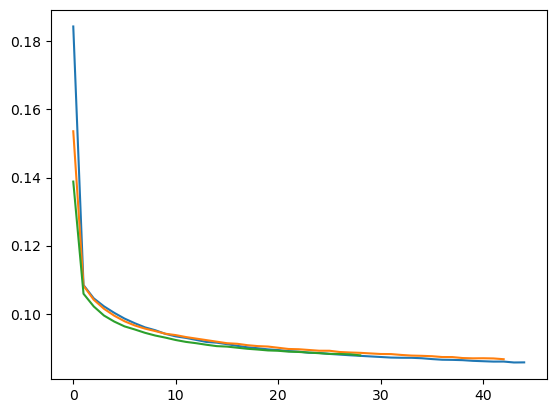

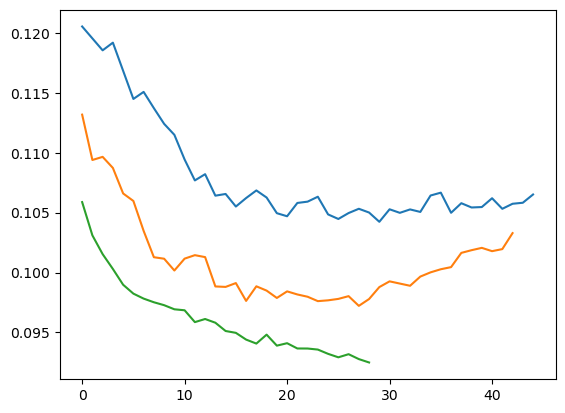


 {'n_node_feat_S': 83, 'n_node_feat_ST': 4, 'n_feat_glob_ST': 15, 'n_edge_feat_S': 0, 'n_edge_feat_ST': 0, 'n_feat_glob_S': 0, 'n_out_final': 1}

 Graph_Sage_mean

 enc_params
edge_params
{'bias': True, 'globals': False, 'nodes_below': False, 'nodes_above': False, 'nodes_depth': True, 'nodes_own': True, 'edge_weights': False, 'project': False, 'initial_loops': False, 'n_feat_node': 87, 'n_out': 87}
node_params
{'bias': True, 'receivers': True, 'nodes_below': False, 'nodes_own': True, 'nodes_above': False, 'nodes_depth': True, 'globals': False, 'normalize': True, 'project': True, 'activation': 'relu', 'n_feat': 174, 'n_out': 50}

 pro_params
edge_params
{'bias': True, 'globals': False, 'nodes_below': False, 'nodes_above': False, 'nodes_depth': False, 'nodes_own': True, 'edge_weights': False, 'project': False, 'initial_loops': False, 'n_feat_node': 50, 'n_out': 50}
node_params
{'bias': True, 'receivers': True, 'nodes_below': False, 'nodes_own': True, 'nodes_above': False, 'nodes_depth':

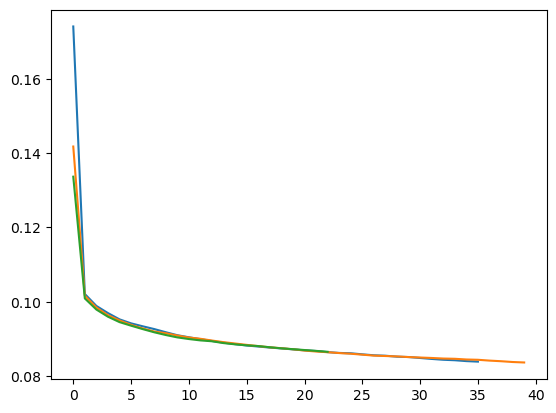

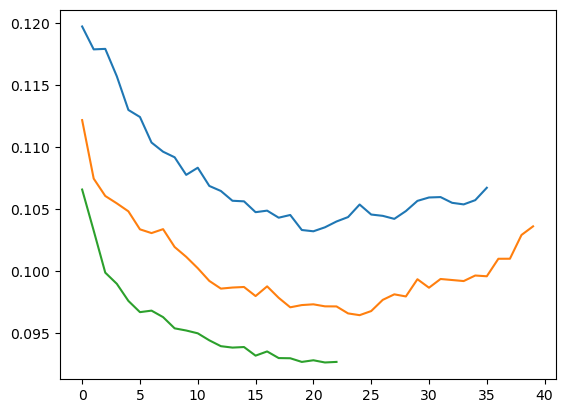


 {'n_node_feat_S': 83, 'n_node_feat_ST': 4, 'n_feat_glob_ST': 15, 'n_edge_feat_S': 0, 'n_edge_feat_ST': 0, 'n_feat_glob_S': 0, 'n_out_final': 1}

 Graph_Attention

 enc_params
edge_params
{'bias': False, 'globals': False, 'nodes_below': False, 'nodes_above': False, 'nodes_depth': True, 'nodes_own': True, 'edge_weights': False, 'project': True, 'activation': None, 'initial_loops': True, 'n_heads': 8, 'n_feat_node': 87, 'n_out': 328}
node_params
{'bias': True, 'receivers': True, 'nodes_below': False, 'nodes_own': False, 'nodes_above': False, 'nodes_depth': False, 'globals': False, 'normalize': True, 'project': False, 'activation': 'relu', 'n_feat': 328, 'n_out': 328}

 pro_params
edge_params
{'bias': False, 'globals': False, 'nodes_below': False, 'nodes_above': False, 'nodes_depth': False, 'nodes_own': True, 'edge_weights': False, 'project': True, 'activation': None, 'initial_loops': True, 'n_heads': 8, 'n_feat_node': 328, 'n_out': 328}
node_params
{'bias': True, 'receivers': True, 'nod

RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [3]:
wfv_splits, train_size, test_size = create_wfv_splits(target_df, n_splits)
# wfv_splits = [[range(0,500), range(500,600)],
#               [range(0,700), range(700, 800)],
#               [range(0,800), range(800, 900)]]
train_size = [target_df.iloc[x].notnull().sum().sum() for x, _ in wfv_splits]
test_size = [target_df.iloc[y].notnull().sum().sum() for _, y in wfv_splits]
print(wfv_splits)
print(device)
adj = create_adjecency_matrix(buurt_polygons).to(device).coalesce().indices()

for n_cluster_with_hid in n_cluster_with_hid_list:
    model_name = n_cluster_with_hid[0]
    n_cluster_nodes = n_cluster_with_hid[1]
    setup_dict["model_name"] = model_name
    setup_dict["n_hid"] = n_cluster_with_hid[2]
    for input_types in input_list:
        input_types = sorted(input_types)
        for node_dropout_prob in [0.05, 0.00]:
            start_time = time.time()
            torch.cuda.empty_cache()
            torch.manual_seed(setup_dict["seed"])
            torch.cuda.manual_seed_all(setup_dict["seed"])
            random.seed(setup_dict["seed"])
            np.random.seed(setup_dict["seed"])
            pooling_dict["node_params"]["dropout_prob"] = node_dropout_prob

            dataset = FST_Dataset(dataset_root, input_types, adj, setup_dict["seq_len"])

            print("\n", dataset.config)
            
            hierarchical_network_params = build_network_params(model_dict[model_name], pooling_dict, dataset.config,
                                                            layer_dict, setup_dict, n_cluster_nodes)
            
            print("\n", model_name)
            for outer_key in hierarchical_network_params.keys():
                for key, val in hierarchical_network_params[outer_key].items():
                    print("\n", key)
                    for val2 in val:
                        for key2, val3 in val2.items():
                            print(key2)
                            my_list = ["broadcast_method", "dropout_prob", "edge_to_node_aggr", "with_edges_own", "n_feat_edge",
                                    "with_edges_below", "with_edges_above", "with_edges_depth", "edge_att_norm",
                                    "softmax_direction", "node_to_node_aggr", "edge_to_edge_aggr", "selection_meth"]
                            print({k.replace("with_", ""): v for k, v in val3.items() if k not in my_list})

            all_losses = {}

            train_losses_df = pd.DataFrame(index=range(setup_dict["max_epochs"]), columns=range(len(wfv_splits)), dtype = np.float64)
            val_losses_df = pd.DataFrame(index=range(setup_dict["max_epochs"]), columns=range(len(wfv_splits)), dtype = np.float64)

            for split_idx, (train_indices, val_indices) in enumerate(wfv_splits):
                if (not training and split_idx < test_idx) or (not testing and split_idx >= test_idx): continue

                if split_idx == 0: print("\n", input_types)
                print('split_idx: {:<2d}'.format(split_idx))
                print('learning rate:', setup_dict["initial_lr"])

                model = RMGN(model_name, setup_dict, dataset.config, n_cluster_nodes, hierarchical_network_params).to(device)
                print("\n", model)
                count_parameters(model, model_name, True, True)

                optimizer = torch.optim.Adam(model.parameters(), lr=setup_dict["initial_lr"], weight_decay = setup_dict["weight_decay"])
                scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=setup_dict["reduce_factor"],
                                                        patience= setup_dict["patience"], 
                                                        verbose=True, min_lr=setup_dict["stop_learning_rate"])

                for epoch in range(setup_dict["max_epochs"]):
                    train_losses, val_losses = [], []
                    training_generator = DataLoader(dataset[list(train_indices)], **params)
                    
                    model.train()
                    total_num_samples = 0
                    for S_graphs in training_generator:
                        S_graphs, ST_graphs = hierarchical_graphs(n_cluster_nodes, S_graphs, 
                                                    model_dict[model_name]["edge_params"]["initial_loops"])
                        S_graphs = [graph.to(device) for graph in S_graphs]
                        ST_graphs = [graph.to(device) for graph in ST_graphs]
                        num_samples = len(S_graphs[0].y)
                        total_num_samples += num_samples
                        
                        optimizer.zero_grad()
                        output, mincut_loss, ortho_loss = model(S_graphs, ST_graphs)
                        output = output.squeeze()[S_graphs[0].mask]
                        
                        prediction_loss = loss_fn(output, S_graphs[0].y)
                        total_loss = prediction_loss + mincut_loss + ortho_loss

                        total_loss.backward()
                        optimizer.step()

                        train_losses.append(prediction_loss.detach().cpu().item() * num_samples)
                    train_losses_df.iloc[epoch, split_idx] = (sum(train_losses) / total_num_samples)**0.5
                    
                    model.eval()
                    total_num_samples = 0
                    val_generator = DataLoader(dataset[list(val_indices)], **params)
                    with torch.no_grad():
                        for S_graphs in val_generator:
                            S_graphs, ST_graphs = hierarchical_graphs(n_cluster_nodes, S_graphs, 
                                                        model_dict[model_name]["edge_params"]["initial_loops"])
                            S_graphs = [graph.to(device) for graph in S_graphs]
                            ST_graphs = [graph.to(device) for graph in ST_graphs]
                            num_samples = len(S_graphs[0].y)
                            total_num_samples += num_samples
                            
                            output, mincut_loss, ortho_loss = model(S_graphs, ST_graphs)
                            output = output.squeeze()[S_graphs[0].mask]

                            prediction_loss = loss_fn(output, S_graphs[0].y)

                            val_losses.append(prediction_loss.detach().cpu().item() * num_samples)
                    val_losses_df.iloc[epoch, split_idx] = (sum(val_losses) / total_num_samples)**0.5
                    scheduler.step(val_losses_df.iloc[epoch, split_idx])

                    print('epoch {:02d}: {:<10f} | {:<10f}'.format(epoch, train_losses_df.iloc[epoch, split_idx], val_losses_df.iloc[epoch, split_idx]))
                    
                    if split_idx >= test_idx and training:
                        if epoch == math.ceil(val_losses_df.iloc[:,:test_idx].idxmin().mean()):
                            if split_idx == len(wfv_splits) - 1:
                                model_dir = create_path(model_root, input_types, dataset)
                                f_name = "_".join([model_name, str(n_cluster_nodes), str(setup_dict["n_hid_layer"]), 
                                                str(node_dropout_prob), str(val_losses_df.iloc[epoch, split_idx])[:6], 
                                                str(train_losses_df.iloc[epoch, split_idx])[:6], str(setup_dict["initial_lr"])])
                                print("saving model!")
                                torch.save(model.state_dict(), model_dir + "/" + f_name)
                            break
                    elif (scheduler._last_lr[0] <= setup_dict["stop_learning_rate"] 
                        or val_losses_df[split_idx].argmin() == epoch - setup_dict["patience"]): 
                        break

            all_losses[", ".join(input_types)] = {"train": train_losses_df, "val": val_losses_df}

            training_loss = train_losses_df.iloc[:,:test_idx].values[val_losses_df.idxmin()[:test_idx], range(test_idx)]
            print('{:>60s} | {:<10f} | {:<10f} |'.format(", ".join(input_types), np.average(training_loss, weights=train_size[:test_idx]),
                                                                                np.average(val_losses_df.min()[:test_idx], weights=test_size[:test_idx])))
            stop_epoch = val_losses_df.iloc[:,-1].last_valid_index()
            print('{:>60s} | {:<10f} | {:<10f} |'.format(", ".join(input_types), np.average(train_losses_df.iloc[stop_epoch, test_idx:], weights = train_size[test_idx:]), 
                                                                                np.average(val_losses_df.iloc[stop_epoch, test_idx:], weights = test_size[test_idx:])))
            train_losses_df.plot(legend=False)
            val_losses_df.plot(legend=False)
            plt.show()

In [ ]:
S_graphs[0].y

In [ ]:
from torch_scatter import scatter_mul 
adj = S_graphs[0].edge_index
s = F.softmax(torch.rand(481, 8), dim=-1)
scatter_mul(adj[0], S_graphs[0].batch)
# out_adj = torch.matmul(torch.matmul(s.transpose(1, 2), adj), s)
# out_adj.shape
s.shape

In [ ]:
def _rank3_trace(x):
    return torch.einsum('ijj->i', x)

def _rank3_diag(x):
    eye = torch.eye(x.size(1)).type_as(x) # Returns a 2-D tensor with ones on the diagonal and zeros elsewhere.
    out = eye * x.unsqueeze(2).expand(*x.size(), x.size(1)) 
    return out

In [ ]:
# MinCut regularization.
mincut_num = _rank3_trace(out_adj)
d_flat = torch.einsum('ijk->ij', adj)
d = _rank3_diag(d_flat)
mincut_den = _rank3_trace(
    torch.matmul(torch.matmul(s.transpose(1, 2), d), s))
mincut_loss = -(mincut_num / mincut_den)
mincut_loss = torch.mean(mincut_loss)

# Orthogonality regularization.
ss = torch.matmul(s.transpose(1, 2), s)
i_s = torch.eye(8).type_as(ss)
ortho_loss = torch.norm(
    ss / torch.norm(ss, dim=(-1, -2), keepdim=True) -
    i_s / torch.norm(i_s), dim=(-1, -2))
ortho_loss = torch.mean(ortho_loss)

EPS = 1e-15

# Fix and normalize coarsened adjacency matrix.
ind = torch.arange(8, device=out_adj.device)
out_adj[:, ind, ind] = 0
d = torch.einsum('ijk->ij', out_adj)
d = torch.sqrt(d)[:, None] + EPS
out_adj = (out_adj / d) / d.transpose(1, 2)

print(mincut_loss, ",", ortho_loss)

In [ ]:
torch.cumsum(torch.tensor([0] + [481] * 32), dim=0)

In [ ]:
adj = create_adjecency_matrix(buurt_polygons).to(device).coalesce().indices()

E = adj.size(1)  # Total number of edges

# Choose a number of edges to select, e.g., E_prime such that E_prime < E
E_prime = E // 8  # Half the edges for example

# Generate a random permutation
perm = torch.randperm(E)

# Select the edges
adj = adj[:, perm[:E_prime]]
adj

In [ ]:
dense_adj = to_dense_adj(adj).cpu()
dense_adj.shape

In [ ]:
list(range(3, -1,-1))

In [ ]:
adj[0].bincount()

In [ ]:
adj[0].bincount().shape